# Header

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math as math
# import janitor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import os

exec(open("../header.py").read())

Header initialized


# Import

In [3]:
threshold = 40

In [60]:
raw_train_data = pd.read_csv(processed_root("03-bag-of-words/threshold-"+str(threshold)+"/bow_train_data.csv"))
raw_val_data = pd.read_csv(processed_root("03-bag-of-words/threshold-"+str(threshold)+"/bow_val_data.csv"))
raw_test_data = pd.read_csv(processed_root("03-bag-of-words/threshold-"+str(threshold)+"/bow_test_data.csv"))

In [4]:
raw_train_data = pd.read_csv(processed_root("04-bow-added-features/feat_train_data-40.csv"))
raw_val_data = pd.read_csv(processed_root("04-bow-added-features/feat_val_data-40.csv"))
raw_test_data = pd.read_csv(processed_root("04-bow-added-features/feat_test_data-40.csv"))

In [5]:
X_train = raw_train_data\
    .drop(['poetry_text', 'poetry_author'], axis = 1)
X_val = raw_val_data\
    .drop(['poetry_text', 'poetry_author'], axis = 1)
y_train = raw_train_data['poetry_author']
y_val = raw_val_data['poetry_author']

In [6]:
len(X_train.columns)

1902

# Evaluate and Tune

In [7]:
def tuning_loop(max_depth_choices):
    
    train_accuracies = []
    val_accuracies = []

    for max_depth in max_depth_choices:
        rf = RandomForestClassifier(max_depth = max_depth, class_weight = "balanced")
        rf.fit(X_train, y_train)
        # Training
        y_pred_train = rf.predict(X_train)
        train_accuracy = np.mean(y_pred_train == y_train) * 100
        train_accuracies.append(train_accuracy)

        # Validation
        y_pred_val = rf.predict(X_val)
        val_accuracy = np.mean(y_pred_val == y_val) * 100
        val_accuracies.append(val_accuracy)
        
    return train_accuracies, val_accuracies

In [8]:
max_depth_choices = [(i+1)*5 for i in range(30)]
train_accuracies, val_accuracies = tuning_loop(max_depth_choices)

In [9]:
def plot_results(md, train, val):
    fig, ax = plt.subplots()
    ax.plot(md, train, label = "Train")
    ax.plot(md, val, label = "Validation")
    ax.set_title("Random Forest Accuracy versus Max Depth")
    ax.set_xlabel("Max Depth")
    ax.set_ylabel("Accuracy (%)")
    ax.legend()
    
    print("Maximum validation accuracy, %.2f%% found at max depth of %d."\
      %(max(val), md[np.argmax(val)]))

Maximum validation accuracy, 67.72% found at max depth of 20.


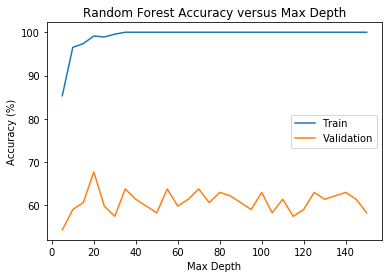

In [10]:
plot_results(max_depth_choices, train_accuracies, val_accuracies)

## Second tune

In [11]:
max_depth_choices2 = [i for i in range(15,26)]
train_accuracies2, val_accuracies2 = tuning_loop(max_depth_choices2)

Maximum validation accuracy, 66.14% found at max depth of 18.


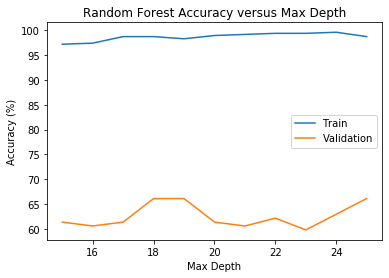

In [12]:
plot_results(max_depth_choices2, train_accuracies2, val_accuracies2)

# Best model

In [13]:
model = RandomForestClassifier(max_depth = 24)

In [14]:
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=24, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [21]:
y_pred_val = model.predict(X_val)

In [26]:
# Training
y_pred_train = model.predict(X_train)
train_accuracy = np.mean(y_pred_train == y_train) * 100
print("Training Accuracy: %.2f%%"%(train_accuracy))

# Validation
y_pred_val = model.predict(X_val)
val_accuracy = np.mean(y_pred_val == y_val) * 100
print("Validation Accuracy: %.2f%%"%(val_accuracy))

Training Accuracy: 99.78%
Validation Accuracy: 59.84%


In [27]:
np.mean(raw_val_data[y_pred_val==y_val].groupby("poetry_author").count()["poetry_text"]/\
raw_val_data.groupby("poetry_author").count()["poetry_text"])

0.5740429505135387

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

In [17]:
author_labels = list(y_val.value_counts().index)

In [18]:
confusion_matrix(y_true = y_val, y_pred = y_pred_val, labels = author_labels)

array([[13,  0,  3,  0,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 4, 10,  1,  0,  0,  0,  0,  0,  0,  1,  0,  0],
       [ 1,  0, 10,  0,  0,  0,  1,  0,  0,  0,  0,  0],
       [ 2,  3,  0,  7,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  0,  0,  0, 11,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  4,  4,  0,  0,  1,  0,  0,  0,  0,  0,  1],
       [ 0,  0,  4,  0,  0,  1,  3,  0,  1,  0,  0,  0],
       [ 4,  0,  1,  1,  0,  0,  0,  2,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  7,  0,  0,  1],
       [ 2,  0,  1,  0,  0,  0,  0,  0,  0,  5,  0,  0],
       [ 4,  1,  2,  0,  0,  0,  0,  0,  0,  0,  1,  0],
       [ 0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  6]])

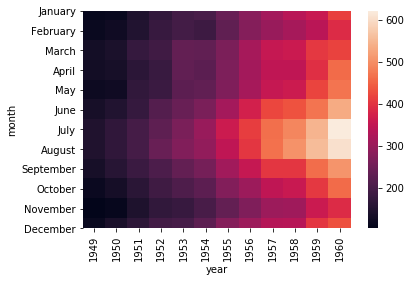

In [19]:
raw_flights = sn.load_dataset("flights")

flights = raw_flights.pivot("month", "year", "passengers")

ax = sn.heatmap(flights)

Text(32.99999999999999, 0.5, 'True')

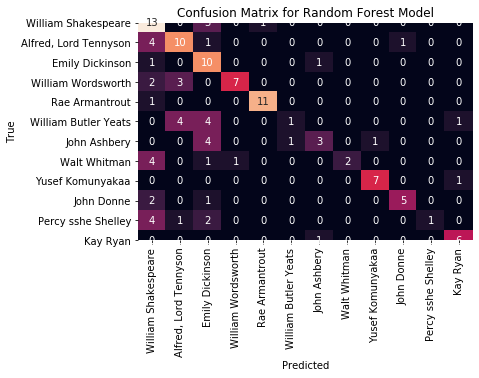

In [20]:
fig, ax = plt.subplots()

sn.heatmap(confusion_matrix(y_true = y_val, y_pred = y_pred_val, labels = author_labels), 
           annot = True,
           xticklabels = author_labels,
           yticklabels = author_labels,
           cbar = False,
           ax = ax)

ax.set_title("Confusion Matrix for Random Forest Model")
ax.set_xlabel("Predicted")
ax.set_ylabel("True")